# Download dataset

In [1]:
# ====================================================================
# 📦 INSTALL REQUIRED LIBRARIES
# ====================================================================
# Run this cell first to install necessary packages

!pip install datasets pillow torch torchvision -q

print("✅ Libraries installed successfully!")

✅ Libraries installed successfully!


In [2]:
# ====================================================================
# 📚 IMPORT LIBRARIES
# ====================================================================

from datasets import load_dataset, concatenate_datasets
from PIL import Image
import torch
from torchvision import transforms
import os
from collections import Counter

print("✅ All imports successful!")

✅ All imports successful!


In [ ]:
import requests
response = requests.get("https://datasets-server.huggingface.co/parquet?dataset=ComplexDataLab/OpenFake")
data = response.json()
# Show first 3 URLs
for i, f in enumerate(data['parquet_files'][:10]):
    print(f"{i}: {f['url']}")

0: https://huggingface.co/datasets/ComplexDataLab/OpenFake/resolve/refs%2Fconvert%2Fparquet/default/test/0000.parquet
1: https://huggingface.co/datasets/ComplexDataLab/OpenFake/resolve/refs%2Fconvert%2Fparquet/default/test/0001.parquet
2: https://huggingface.co/datasets/ComplexDataLab/OpenFake/resolve/refs%2Fconvert%2Fparquet/default/test/0002.parquet
3: https://huggingface.co/datasets/ComplexDataLab/OpenFake/resolve/refs%2Fconvert%2Fparquet/default/test/0003.parquet
4: https://huggingface.co/datasets/ComplexDataLab/OpenFake/resolve/refs%2Fconvert%2Fparquet/default/test/0004.parquet
5: https://huggingface.co/datasets/ComplexDataLab/OpenFake/resolve/refs%2Fconvert%2Fparquet/default/test/0005.parquet
6: https://huggingface.co/datasets/ComplexDataLab/OpenFake/resolve/refs%2Fconvert%2Fparquet/default/test/0006.parquet
7: https://huggingface.co/datasets/ComplexDataLab/OpenFake/resolve/refs%2Fconvert%2Fparquet/default/test/0007.parquet
8: https://huggingface.co/datasets/ComplexDataLab/OpenFa

In [4]:
import os
import requests
from tqdm.auto import tqdm
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Setup Paths
# This will save files to your Google Drive in a folder named 'deepfake_data'
save_dir = "/content/drive/MyDrive/deepfake_data"
os.makedirs(save_dir, exist_ok=True)

dataset_name = "ComplexDataLab/OpenFake"
# How many shards you want to collect in total
total_shards_to_collect = 5

def download_shard_to_drive(shard_index, target_path):
    url = f"https://huggingface.co/api/datasets/{dataset_name}/parquet/default/train/{shard_index}.parquet"

    # Use stream=True to keep RAM usage near ZERO
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))

    print(f"📥 Downloading Shard {shard_index} to Google Drive...")
    with open(target_path, 'wb') as f, tqdm(
        total=total_size,
        unit='iB',
        unit_scale=True,
        desc=f"Shard {shard_index}"
    ) as bar:
        for data in response.iter_content(chunk_size=1024*1024): # 1MB chunks
            f.write(data)
            bar.update(len(data))

# ====================================================================
# 📥 THE LOOP: DOWNLOAD 1 BY 1
# ====================================================================

for i in range(total_shards_to_collect):
    file_path = os.path.join(save_dir, f"train-{i:05d}.parquet")

    if os.path.exists(file_path):
        print(f"✅ Shard {i} already exists on Drive. Skipping.")
        continue

    try:
        download_shard_to_drive(i, file_path)
        print(f"✨ Successfully saved Shard {i} to Drive.\n")
    except Exception as e:
        print(f"❌ Error on Shard {i}: {e}")

print("🏁 All requested shards are now safely stored on your Google Drive!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📥 Downloading Shard 5 to Google Drive...


Shard 5:   0%|          | 0.00/2.03G [00:00<?, ?iB/s]

✨ Successfully saved Shard 5 to Drive.
📝 Renamed to: test.parquet
🏁 Done!


🔎 Found 5 parquet files. Analyzing metadata only...

📊 --- COUNTING LABELS (Skipping Images) ---
   ✅ Scanned train-00000.parquet: 9081 rows
   ✅ Scanned train-00001.parquet: 3557 rows
   ✅ Scanned train-00002.parquet: 9081 rows
   ✅ Scanned train-00003.parquet: 3557 rows
   ✅ Scanned train-00004.parquet: 9081 rows

   🔢 Total Images: 34,357
   ⚖️ Label Distribution:
      • real: 17,258 (50.2%)
      • fake: 17,099 (49.8%)

🖼️ --- LOADING SAMPLES (Streaming Mode) ---
   ⏳ Fetching 5 Real images...
   ⏳ Fetching 5 Fake images...


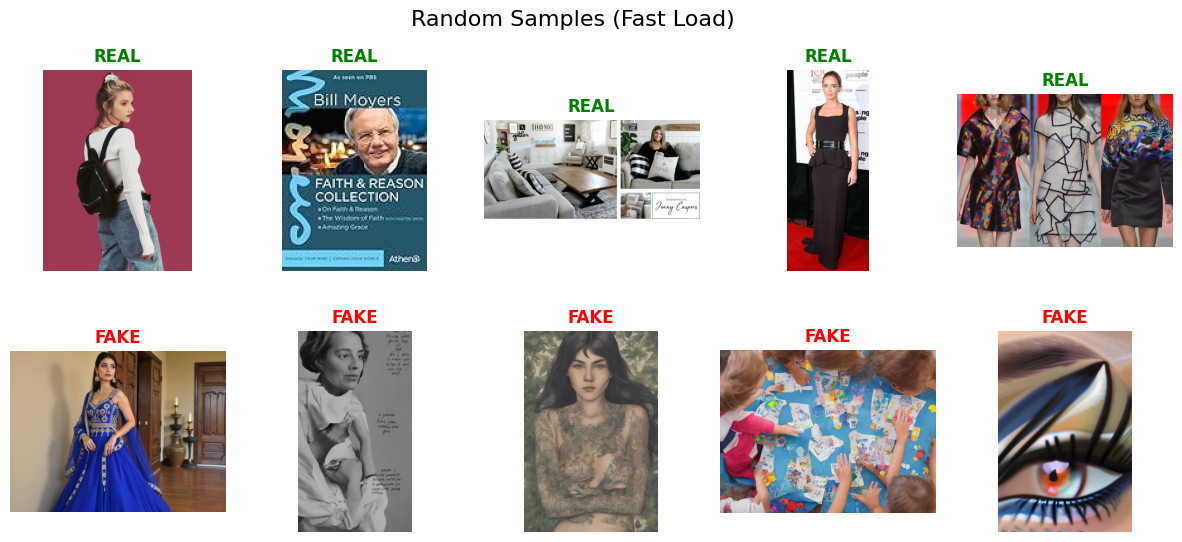

In [ ]:
# ==============================================================================
# ⚡ FAST EDA: Reads Metadata ONLY (Skips Heavy Images)
# ==============================================================================
import os
import glob
import random
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from collections import Counter
from io import BytesIO
from PIL import Image

# ⚙️ CONFIG
DATA_PATH = "/content/drive/MyDrive/deepfake_data"
files = sorted(glob.glob(os.path.join(DATA_PATH, "*.parquet")))

print(f"🔎 Found {len(files)} parquet files. Analyzing metadata only...\n")

# --------------------------------------------------------------------------
# 1. FAST STATS (Pandas only reads the 'label' column)
# --------------------------------------------------------------------------
total_rows = 0
all_labels = []

print("📊 --- COUNTING LABELS (Skipping Images) ---")
for f in files:
    # 🚀 TRICK: We only read the 'label' column. This takes seconds, not hours.
    df_temp = pd.read_parquet(f, columns=["label"])
    total_rows += len(df_temp)
    all_labels.extend(df_temp["label"].tolist())
    print(f"   ✅ Scanned {os.path.basename(f)}: {len(df_temp)} rows")

counts = Counter(all_labels)
print(f"\n   🔢 Total Images: {total_rows:,}")
print(f"   ⚖️ Label Distribution:")
for label, count in counts.items():
    percent = (count / total_rows) * 100
    print(f"      • {label}: {count:,} ({percent:.1f}%)")

# --------------------------------------------------------------------------
# 2. FAST VISUALIZATION (Streaming)
# --------------------------------------------------------------------------
print("\n🖼️ --- LOADING SAMPLES (Streaming Mode) ---")

# 🚀 STREAMING=TRUE: This downloads/reads only the specific 10 images we need
ds = load_dataset("parquet", data_files=files, split="train", streaming=True)

# Helper to get samples
def get_samples(target_label, num=5):
    found = []
    # We iterate through the stream until we find 5 of the right label
    for sample in ds:
        if sample['label'] == target_label:
            found.append(sample['image'])
        if len(found) == num:
            break
    return found

print("   ⏳ Fetching 5 Real images...")
samples_real = get_samples("real", 5)
print("   ⏳ Fetching 5 Fake images...")
samples_fake = get_samples("fake", 5)

# Plotting
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle(f"Random Samples (Fast Load)", fontsize=16)

# Row 1: Real
for i in range(5):
    if i < len(samples_real):
        axes[0, i].imshow(samples_real[i])
        axes[0, i].set_title("REAL", color="green", weight="bold")
        axes[0, i].axis('off')

# Row 2: Fake
for i in range(5):
    if i < len(samples_fake):
        axes[1, i].imshow(samples_fake[i])
        axes[1, i].set_title("FAKE", color="red", weight="bold")
        axes[1, i].axis('off')

plt.show()

🔍 Checking Columns & Metadata...
   🔑 Columns found: ['image', 'prompt', 'label', 'model', 'type', 'release_date']
   ⚠️ No specific generator metadata found in standard columns.

📏 Scanning 1,000 images for Size & Mode (Streaming)...


  0%|          | 0/1000 [00:00<?, ?it/s]


📋 --- DIAGNOSTIC REPORT ---
🎨 Color Modes:
RGB     999
RGBA      1

   ⚠️ WARNING: You have Non-RGB images!
   👉 ACTION: You MUST add a '.convert('RGB')' step in your preprocessing.

📐 Dimensions (WxH):
   • Average: 783 x 752
   • Smallest: 100 x 102
   • Largest:  2667 x 4000


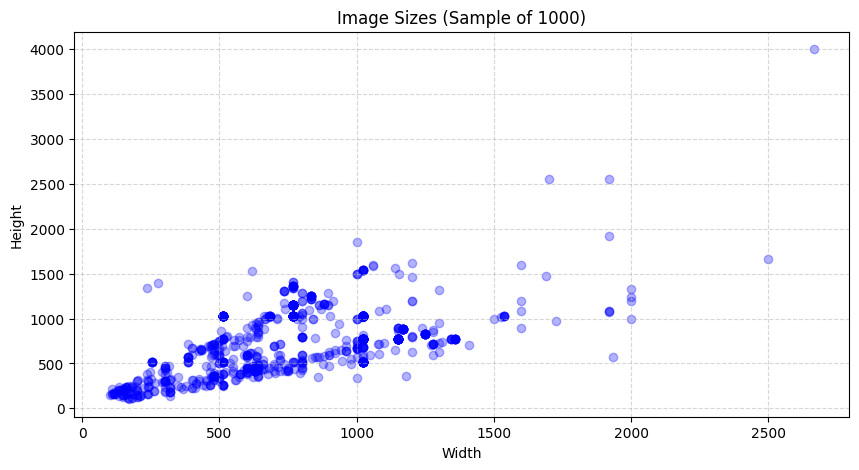

   ℹ️ NOTE: High-res images detected. Your Data Loader needs a Resize(224) step.


In [ ]:
# ==============================================================================
# 🩺 ADVANCED EDA: Geometry, Channels, and Hidden Metadata
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm.auto import tqdm
import os
import glob

# ⚙️ CONFIG
DATA_PATH = "/content/drive/MyDrive/deepfake_data"
files = sorted(glob.glob(os.path.join(DATA_PATH, "*.parquet")))

print("🔍 Checking Columns & Metadata...")
# 1. Check for hidden columns (What AI model made these?)
df_head = pd.read_parquet(files[0])
print(f"   🔑 Columns found: {df_head.columns.tolist()}")
if 'metadata' in df_head.columns or 'subset' in df_head.columns:
    print("   ✨ EXTRA METADATA FOUND! We can analyze generator types.")
else:
    print("   ⚠️ No specific generator metadata found in standard columns.")

# --------------------------------------------------------------------------
# 2. SCANNING IMAGE GEOMETRY (Sample 1000 images)
# --------------------------------------------------------------------------
print("\n📏 Scanning 1,000 images for Size & Mode (Streaming)...")
ds = load_dataset("parquet", data_files=files, split="train", streaming=True)

widths = []
heights = []
modes = []
count = 0
limit = 1000

for sample in tqdm(ds, total=limit):
    img = sample['image']

    # Record dimensions
    w, h = img.size
    widths.append(w)
    heights.append(h)

    # Record Mode (RGB, L, CMYK, etc.)
    modes.append(img.mode)

    count += 1
    if count >= limit:
        break

# --------------------------------------------------------------------------
# 3. REPORT
# --------------------------------------------------------------------------
print("\n📋 --- DIAGNOSTIC REPORT ---")

# A. Color Channels
mode_counts = pd.Series(modes).value_counts()
print(f"🎨 Color Modes:\n{mode_counts.to_string()}")

if 'L' in mode_counts or 'RGBA' in mode_counts:
    print("\n   ⚠️ WARNING: You have Non-RGB images!")
    print("   👉 ACTION: You MUST add a '.convert('RGB')' step in your preprocessing.")
else:
    print("\n   ✅ All scanned images are Standard RGB.")

# B. Image Sizes
avg_w = sum(widths) / len(widths)
avg_h = sum(heights) / len(heights)
min_w, max_w = min(widths), max(widths)
min_h, max_h = min(heights), max(heights)

print(f"\n📐 Dimensions (WxH):")
print(f"   • Average: {int(avg_w)} x {int(avg_h)}")
print(f"   • Smallest: {min_w} x {min_h}")
print(f"   • Largest:  {max_w} x {max_h}")

# Visualizing Aspect Ratios
plt.figure(figsize=(10, 5))
plt.scatter(widths, heights, alpha=0.3, color='blue')
plt.title(f"Image Sizes (Sample of {limit})")
plt.xlabel("Width")
plt.ylabel("Height")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

if max_w > 1000 or max_h > 1000:
    print("   ℹ️ NOTE: High-res images detected. Your Data Loader needs a Resize(224) step.")

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class SafeOpenFakeDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.ds = hf_dataset
        self.transform = transform
        # Define label mapping: Real=0, Fake=1
        self.label_map = {'real': 0, 'fake': 1}

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]
        image = item['image']
        label_str = item['label']

        # 🛠️ FIX 1: Handle Non-RGB (The RGBA issue)
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # 🛠️ FIX 2: Handle Dimensions (Resize is usually done in 'transform')
        if self.transform:
            image = self.transform(image)

        # 🛠️ FIX 3: Convert String Label to Integer
        label = self.label_map.get(label_str, -1) # Returns -1 if something is wrong

        return image, torch.tensor(label, dtype=torch.float32)

# Usage Example:
# Define the "Safety" transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # squish everything to 224x224
    transforms.ToTensor(),
])

# Wrap your dataset
# safe_dataset = SafeOpenFakeDataset(dataset_raw, transform=train_transforms)

In [ ]:
import pandas as pd
import glob
import os

DATA_PATH = "/content/drive/MyDrive/deepfake_data"
files = sorted(glob.glob(os.path.join(DATA_PATH, "*.parquet")))

# Read just the 'model' column from the first few files
print("🤖 Checking Generator Distribution...")
all_models = []
for f in files:
    df = pd.read_parquet(f, columns=["model"])
    # Filter out None/Null values (usually Real images have no model)
    fakes = df[df['model'].notna()]['model']
    all_models.extend(fakes.tolist())

from collections import Counter
print(Counter(all_models))

🤖 Checking Generator Distribution...
Counter({'real': 17258, 'sd-3.5': 2525, 'sd-2.1': 2409, 'flux.1-dev': 1965, 'sdxl-epic-realism': 1131, 'midjourney-6': 881, 'gpt-image-1': 737, 'sdxl': 730, 'sd-1.5-dreamshaper': 631, 'sdxl-touchofrealism': 627, 'flux.1-schnell': 613, 'dalle-3': 555, 'flux-1.1-pro': 533, 'sdxl-realvis-v5': 511, 'ideogram-3.0': 509, 'hidream-i1-full': 495, 'sdxl-juggernaut': 445, 'sd-1.5': 355, 'sd-1.5-epicdream': 345, 'flux-mvc5000': 270, 'mystic': 261, 'imagen-4.0': 170, 'grok-2-image-1212': 167, 'chroma': 74, 'imagen-3.0-002': 63, 'flux-amateursnapshotphotos': 48, 'midjourney-7': 40, 'flux-realism': 9})


In [ ]:
import os
import glob
import torch
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

# ==============================================================================
# 1. SETUP & TRANSFORMS
# ==============================================================================
BATCH_SIZE = 32  # Good size for EfficientNet/MobileNet on L4/T4
IMG_SIZE = 224   # Standard for most pre-trained models

# Define the preprocessing steps
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Fix the 4000px issue
    transforms.ToTensor(),                    # Convert to PyTorch Tensor
    # Standard ImageNet normalization (helps model learn faster)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ==============================================================================
# 2. THE SAFETY DATASET CLASS
# ==============================================================================
class SafeOpenFakeDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.ds = hf_dataset
        self.transform = transform
        self.label_map = {'real': 0, 'fake': 1} # Real=0, Fake=1

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]
        image = item['image']
        label_str = item['label']

        # 🛠️ FIX: Handle Non-RGB (The RGBA issue)
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Apply transforms (Resize, ToTensor, Normalize)
        if self.transform:
            image = self.transform(image)

        # Convert label string to number
        label = self.label_map.get(label_str, 0) # Default to 0 if error

        return image, torch.tensor(label, dtype=torch.float32)

# ==============================================================================
# 3. LOAD & SPLIT
# ==============================================================================
DATA_PATH = "/content/drive/MyDrive/deepfake_data"
files = sorted(glob.glob(os.path.join(DATA_PATH, "*.parquet")))

print("📂 Loading Parquet files from Drive...")
# Load raw data (metadata only first)
raw_dataset = load_dataset("parquet", data_files=files, split="train")

# Wrap it in our Safety Class
full_dataset = SafeOpenFakeDataset(raw_dataset, transform=train_transforms)

# Calculate Split Sizes (80% Train, 20% Validation)
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size

print(f"✂️ Splitting {total_size} images into:")
print(f"   • Train: {train_size}")
print(f"   • Val:   {val_size}")

# Random Split
train_ds, val_ds = random_split(full_dataset, [train_size, val_size])

# ==============================================================================
# 4. CREATE DATALOADERS
# ==============================================================================
# Num_workers=2 is usually safe for Colab. If it crashes, set to 0.
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("\n✅ DataLoaders are ready!")
print("   Run 'next(iter(train_loader))' to test a batch.")

📂 Loading Parquet files from Drive...


Generating train split: 0 examples [00:00, ? examples/s]

Loading dataset shards:   0%|          | 0/34 [00:00<?, ?it/s]

✂️ Splitting 34357 images into:
   • Train: 27485
   • Val:   6872

✅ DataLoaders are ready!
   Run 'next(iter(train_loader))' to test a batch.


In [ ]:
# Get one batch of data
images, labels = next(iter(train_loader))

print(f"📦 Batch Shape: {images.shape}")
print(f"🏷️ Labels Shape: {labels.shape}")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


📦 Batch Shape: torch.Size([32, 3, 224, 224])
🏷️ Labels Shape: torch.Size([32])


In [ ]:
import os
import glob
from datasets import load_dataset, DatasetDict

# ==============================================================================
# 1. SETUP PATHS
# ==============================================================================
# Input: Where your 5 parquet files are currently sitting
RAW_DATA_PATH = "/content/drive/MyDrive/deepfake_data"

# Output: New folder to save the processed splits
SAVE_PATH = "/content/drive/MyDrive/deepfake_data/ready_to_train_splits"

# ==============================================================================
# 2. LOAD & SPLIT (Hugging Face Method)
# ==============================================================================
print("📂 Loading raw parquet files...")
files = sorted(glob.glob(os.path.join(RAW_DATA_PATH, "*.parquet")))

# Load the full dataset
full_ds = load_dataset("parquet", data_files=files, split="train")

print(f"   Total images loaded: {len(full_ds)}")

# ✂️ SPLIT: 80% Train, 20% Validation
# We use a fixed seed=42 so this split is reproducible
print("✂️ Performing 80/20 Train-Validation split...")
split_ds = full_ds.train_test_split(test_size=0.2, seed=42)

# Rename 'test' to 'validation' for clarity
split_ds['validation'] = split_ds.pop('test')

print(f"   • Train set: {len(split_ds['train'])} images")
print(f"   • Val set:   {len(split_ds['validation'])} images")

# ==============================================================================
# 3. SAVE TO DRIVE
# ==============================================================================
print(f"\n💾 Saving split dataset to: {SAVE_PATH}...")
print("   (This might take a few minutes as it writes to Drive...)")

# This saves the actual arrow files, so loading later is INSTANT
split_ds.save_to_disk(SAVE_PATH)

print("\n✅ SUCCESS! Dataset saved.")
print(f"   Train path: {os.path.join(SAVE_PATH, 'train')}")
print(f"   Val path:   {os.path.join(SAVE_PATH, 'validation')}")

📂 Loading raw parquet files...


Loading dataset shards:   0%|          | 0/34 [00:00<?, ?it/s]

   Total images loaded: 34357
✂️ Performing 80/20 Train-Validation split...
   • Train set: 27485 images
   • Val set:   6872 images

💾 Saving split dataset to: /content/drive/MyDrive/deepfake_data/ready_to_train_splits...
   (This might take a few minutes as it writes to Drive...)


Saving the dataset (0/31 shards):   0%|          | 0/27485 [00:00<?, ? examples/s]

Saving the dataset (0/8 shards):   0%|          | 0/6872 [00:00<?, ? examples/s]


✅ SUCCESS! Dataset saved.
   Train path: /content/drive/MyDrive/deepfake_data/ready_to_train_splits/train
   Val path:   /content/drive/MyDrive/deepfake_data/ready_to_train_splits/validation


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from datasets import load_from_disk

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import io

# ==============================================================================
# 1. ROBUST DATASET CLASS WITH CORRUPTION HANDLING (FIXED)
# ==============================================================================
class SafeOpenFakeDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.ds = hf_dataset
        self.transform = transform
        self.label_map = {'real': 0, 'fake': 1}

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        max_retries = 5
        original_idx = idx

        for attempt in range(max_retries):
            try:
                item = self.ds[idx]
                image = item['image']

                # Handle if image is bytes instead of PIL Image
                if not isinstance(image, Image.Image):
                    try:
                        image = Image.open(io.BytesIO(image))
                    except Exception:
                        raise ValueError("Cannot open image from bytes")

                # Handle Palette/Transparency explicitly
                if image.mode != 'RGB':
                    if image.mode == 'P':  # Palette mode
                        image = image.convert('RGBA').convert('RGB')
                    elif image.mode == 'RGBA':
                        image = image.convert('RGB')
                    else:
                        image = image.convert('RGB')

                if self.transform:
                    image = self.transform(image)

                label = self.label_map.get(item['label'], 0)

                # --- FIX STARTS HERE ---
                # Return a dictionary, not a tuple
                return {
                    "pixel_values": image,
                    "labels": torch.tensor(label, dtype=torch.long) # Changed to long for classification
                }
                # --- FIX ENDS HERE ---

            except Exception as e:
                # Skip to next image if corrupted
                print(f"⚠️ Skipping corrupted image at idx {idx} (attempt {attempt+1}/{max_retries}): {str(e)[:50]}")
                idx = (idx + 1) % len(self.ds)

                # On last attempt, return a black dummy image
                if attempt == max_retries - 1:
                    print(f"❌ Failed to load after {max_retries} attempts, using dummy image")
                    dummy_image = Image.new('RGB', (224, 224), color='black')
                    if self.transform:
                        dummy_image = self.transform(dummy_image)

                    # Return dictionary for dummy image as well
                    return {
                        "pixel_values": dummy_image,
                        "labels": torch.tensor(0, dtype=torch.long)
                    }

        raise RuntimeError(f"Failed to load image at idx {original_idx} after {max_retries} attempts")

print("✅ SafeOpenFakeDataset updated with corruption handling and correct return format.")

✅ SafeOpenFakeDataset updated with corruption handling and correct return format.


In [ ]:
# ==============================================================================
# 1. DEFINE HYPERPARAMETERS & TRANSFORMS
# ==============================================================================
BATCH_SIZE = 256
IMG_SIZE = 224

# Define how to modify the images before they go into the model
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),   # Resize 4000px -> 224px
    transforms.ToTensor(),                     # Convert to numbers (0-1)
    # Standard ImageNet normalization colors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation usually uses the same transform (resize + normalize)
val_transforms = train_transforms


In [ ]:
import shutil
import os
from tqdm import tqdm
from datasets import load_from_disk

source = "/content/drive/MyDrive/deepfake_data/ready_to_train_splits"
destination = "/content/ready_to_train_splits"

# Check if already exists
if os.path.exists(destination):
    print(f"✅ Dataset already exists at {destination}, skipping copy...")
else:
    print("🚀 Copying 20GB dataset with progress tracking...")

    # Count total files first
    def count_files(directory):
        total = 0
        for root, dirs, files in os.walk(directory):
            total += len(files)
        return total

    total_files = count_files(source)
    print(f"📊 Total files to copy: {total_files}")

    # Copy with progress bar
    copied = 0
    with tqdm(total=total_files, desc="Copying files") as pbar:
        def copy_with_progress(src, dst):
            global copied
            shutil.copy2(src, dst)
            copied += 1
            pbar.update(1)

        shutil.copytree(source, destination, copy_function=copy_with_progress)

    print("✅ DONE! All files copied to local storage")

# Load the data (always execute this part)
print(f"📂 Loading dataset from {destination}...")
dataset_splits = load_from_disk(destination)
train_ds_raw = dataset_splits['train']
val_ds_raw = dataset_splits['validation']
print(f"✅ Loaded: {len(train_ds_raw)} Train, {len(val_ds_raw)} Val")

✅ Dataset already exists at /content/ready_to_train_splits, skipping copy...
📂 Loading dataset from /content/ready_to_train_splits...


Loading dataset from disk:   0%|          | 0/31 [00:00<?, ?it/s]

✅ Loaded: 27485 Train, 6872 Val


In [ ]:
# ==============================================================================
# 3. WRAP IN SAFETY DATASET
# ==============================================================================
# Now 'train_transforms' exists, so this will work!
train_dataset = SafeOpenFakeDataset(train_ds_raw, transform=train_transforms)
val_dataset = SafeOpenFakeDataset(val_ds_raw, transform=val_transforms)

In [ ]:
# ==============================================================================
# 4. CREATE DATALOADERS (Final Step)
# ==============================================================================
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [ ]:
# ==============================================================================
# 3. SETUP WEIGHTS & BIASES (Login Only)
# ==============================================================================
import wandb

# 1. Install
print("⬇️ Installing WandB...")
!pip install wandb -qU

# 2. Login
# Copy the API key from your screenshot (starts with 8453...)
# Paste it in the box below and hit Enter.
print("🔑 Logging in...")
wandb.login()

print("✅ Login Successful! We will initialize specific runs later for each model.")

⬇️ Installing WandB...
🔑 Logging in...


wandb: Currently logged in as: haeriz42069 (haeriz42069-universitas-muhammadiyah-malang) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✅ Login Successful! We will initialize specific runs later for each model.


In [ ]:
# Re-create the dataset objects
train_dataset = SafeOpenFakeDataset(train_ds_raw, transform=train_transforms)
val_dataset = SafeOpenFakeDataset(val_ds_raw, transform=val_transforms)

# 🛠️ FIX: num_workers=0 prevents the freezing/deadlock in Colab
BATCH_SIZE = 512
# Use num_workers=2 with persistent workers (more stable than 4)
train_loader = DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=True,
    num_workers=2,              # ← Try 2 instead of 0 or 4
    persistent_workers=True,    # ← Keeps workers alive between epochs
    prefetch_factor=2,          # ← Prefetch batches
    pin_memory=True             # ← Faster GPU transfer
)

val_loader = DataLoader(
    val_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=2,
    persistent_workers=True,
    prefetch_factor=2,
    pin_memory=True
)

print("✅ DataLoaders with optimized settings")

✅ DataLoaders with optimized settings


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# ==============================================================================
# 2. DEFINE MODEL 1: CUSTOM CNN
# ==============================================================================
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        # Block 1: 3 -> 32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2) # Reduces dimension by half

        # Block 2: 32 -> 64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Block 3: 64 -> 128
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Block 4: 128 -> 256
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # Dropout to prevent overfitting
        self.dropout = nn.Dropout(0.5)

        # Global Average Pooling (Squashes 14x14x256 -> 1x1x256)
        # This keeps the parameter count very low (~500k)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Classification Head
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 1) # Output 1 score (Real vs Fake)

    def forward(self, x):
        # Block 1
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        # Block 2
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        # Block 3
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        # Block 4
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        # Classifier
        x = self.global_pool(x)
        x = x.view(x.size(0), -1) # Flatten
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # No Sigmoid here! We use BCEWithLogitsLoss
        return x

# Verify Parameter Count
model = CustomCNN()
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"🧠 Model 1 Created. Total Trainable Parameters: {params:,}")
# Expected: ~400k - 500k

🧠 Model 1 Created. Total Trainable Parameters: 422,401


In [ ]:
import torch.optim as optim
import wandb
import torch
import time
import torch.nn as nn
from tqdm.auto import tqdm # <--- Added Progress Bar back

# ==============================================================================
# 1. SETUP (Workers=0)
# ==============================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Training on: {device}")

model = CustomCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ==============================================================================
# 2. INIT WANDB
# ==============================================================================
if wandb.run is not None: wandb.finish()
wandb.init(project="UAP", name="Model_1_With_ProgressBar", config={"architecture": "CustomCNN", "epochs": 30})

wandb.define_metric("global_step")
wandb.define_metric("train/*", step_metric="global_step")
wandb.define_metric("val/*", step_metric="global_step")

# ==============================================================================
# 3. TRAINING LOOP
# ==============================================================================
EPOCHS = 3
global_step = 0

print(f"\n🏁 Starting Training...")
print("-" * 95)
print(f"{'Epoch':<8} | {'Train Loss':<12} | {'Train Acc':<12} | {'Val Loss':<12} | {'Val Acc':<12} | {'Time':<8}")
print("-" * 95)

for epoch in range(EPOCHS):
    start_time = time.time()

    # --- TRAIN ---
    model.train()
    train_loss_accum = 0.0
    train_correct = 0
    train_total = 0

    # ⚡ PROGRESS BAR ADDED HERE
    # leave=False means it disappears when done, keeping the table clean
    train_loop = tqdm(train_loader, desc=f"Ep {epoch+1}/{EPOCHS}", leave=False)

    for inputs, labels in train_loop:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Live Metrics
        preds = torch.sigmoid(outputs) > 0.5
        batch_acc = (preds == labels).float().mean().item()

        # 1. Update Progress Bar Text
        train_loop.set_postfix(loss=f"{loss.item():.4f}", acc=f"{batch_acc:.4f}")

        # 2. Log to WandB
        wandb.log({
            "train/loss": loss.item(),
            "train/accuracy": batch_acc,
            "global_step": global_step
        })

        global_step += 1
        train_loss_accum += loss.item() * inputs.size(0)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    # --- VALIDATE ---
    model.eval()
    val_loss_accum = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss_accum += loss.item() * inputs.size(0)
            preds = torch.sigmoid(outputs) > 0.5
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    # --- STATS ---
    train_loss = train_loss_accum / train_total
    train_acc = train_correct / train_total
    val_loss = val_loss_accum / val_total
    val_acc = val_correct / val_total
    elapsed = time.time() - start_time

    # Log Val
    wandb.log({
        "val/loss": val_loss,
        "val/accuracy": val_acc,
        "global_step": global_step
    })

    # --- PRINT TABLE ROW ---
    print(f"{epoch+1:<8} | {train_loss:<12.4f} | {train_acc:<12.4f} | {val_loss:<12.4f} | {val_acc:<12.4f} | {elapsed:.0f}s")

print("-" * 95)
print("✅ Training Complete.")
wandb.finish()
torch.save(model.state_dict(), "base_cnn_final.pth")

🚀 Training on: cuda



🏁 Starting Training...
-----------------------------------------------------------------------------------------------
Epoch    | Train Loss   | Train Acc    | Val Loss     | Val Acc      | Time    
-----------------------------------------------------------------------------------------------


Ep 1/3:   0%|          | 0/108 [00:00<?, ?it/s]

⚠️ Skipping corrupted image at idx 4743 (attempt 1/5): cannot identify image file <_io.BytesIO object at 
1        | 0.5996       | 0.6731       | 0.7730       | 0.5423       | 375s


Ep 2/3:   0%|          | 0/108 [00:00<?, ?it/s]

⚠️ Skipping corrupted image at idx 4743 (attempt 1/5): cannot identify image file <_io.BytesIO object at 
2        | 0.5641       | 0.7093       | 0.5477       | 0.7174       | 372s


Ep 3/3:   0%|          | 0/108 [00:00<?, ?it/s]

⚠️ Skipping corrupted image at idx 4743 (attempt 1/5): cannot identify image file <_io.BytesIO object at 
3        | 0.5322       | 0.7357       | 0.5989       | 0.6989       | 368s
-----------------------------------------------------------------------------------------------
✅ Training Complete.


global_step,▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
train/accuracy,▁▃▃▅▄▄▄▃▅▅▅▅▅▅▆▆▅▆▆▆▆▇▅▅▆▆█▇▆▆▅▅▆▆▇█▆▆▇▇
train/loss,█▅▆▆▅▅▇▇▆▄▄▅▆▅▃▄▄▅▄▄▃▃█▅▄▄▄▅▃▃▄▁▃▁▃▁▃▄▅▃
val/accuracy,▁█▇
val/loss,█▁▃
global_step,324
train/accuracy,0.74194
train/loss,0.58486
val/accuracy,0.69892
val/loss,0.5989


In [ ]:
pip install safetensors

In [ ]:
from safetensors.torch import save_file

In [ ]:
from google.colab import drive
import torch
import os
from safetensors.torch import save_file

# 1. Mount Google Drive (You might get a popup asking for permission)
drive.mount('/content/drive')

# 2. Define Paths
source_file = "base_cnn_final.pth"

# Best Practice Name: lowercase, underscores, version number
dest_folder = "/content/drive/MyDrive/deepfake_data/MODEL/Base_model"
dest_filename = "deepfake_base_v1.safetensors"
dest_path = os.path.join(dest_folder, dest_filename)

# 3. Create the folder in Drive if it doesn't exist
os.makedirs(dest_folder, exist_ok=True)

# 4. Convert and Save directly to Drive
if os.path.exists(source_file):
    print(f"🔄 Reading local checkpoint: {source_file}...")

    # Load weights (CPU safe)
    weights = torch.load(source_file, map_location="cpu")

    print(f"💾 Saving directly to Drive: {dest_path}...")
    save_file(weights, dest_path)

    file_size = os.path.getsize(dest_path) / (1024 * 1024)
    print(f"✅ SUCCESS! Model saved.")
    print(f"📍 Location: {dest_path}")
    print(f"📊 Size: {file_size:.2f} MB")
else:
    print(f"❌ ERROR: Could not find '{source_file}' in the current folder.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🔄 Reading local checkpoint: base_cnn_final.pth...
💾 Saving directly to Drive: /content/drive/MyDrive/deepfake_data/MODEL/Base_model/deepfake_base_v1.safetensors...
✅ SUCCESS! Model saved.
📍 Location: /content/drive/MyDrive/deepfake_data/MODEL/Base_model/deepfake_base_v1.safetensors
📊 Size: 1.62 MB


In [ ]:
import torch
import os
import numpy as np
import wandb
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from transformers import (
    AutoModelForImageClassification,
    TrainingArguments,
    Trainer,
    DefaultDataCollator
)

In [ ]:
# ==============================================================================
# 1. CONFIG & METRICS
# ==============================================================================
model_checkpoint = "timm/tf_efficientnetv2_s.in21k"
output_dir = "/content/drive/MyDrive/deepfake_checkpoints/efficientnet_finetuned"

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # predictions are logits
    probs = torch.nn.functional.softmax(torch.tensor(predictions), dim=-1).numpy()
    preds = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)

    try:
        auc = roc_auc_score(labels, probs[:, 1])
    except:
        auc = 0.0

    return {
        "accuracy": accuracy,
        "f1": f1,
        "auc": auc
    }


In [ ]:
# ==============================================================================
# 2. MODEL SETUP
# ==============================================================================
print(f"📥 Loading {model_checkpoint}...")
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    num_labels=2,
    ignore_mismatched_sizes=True
)

# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

📥 Loading timm/tf_efficientnetv2_s.in21k...


config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/193M [00:00<?, ?B/s]

Some weights of TimmWrapperForImageClassification were not initialized from the model checkpoint at timm/tf_efficientnetv2_s.in21k and are newly initialized because the shapes did not match:
- timm_model.classifier.bias: found shape torch.Size([21843]) in the checkpoint and torch.Size([2]) in the model instantiated
- timm_model.classifier.weight: found shape torch.Size([21843, 1280]) in the checkpoint and torch.Size([2, 1280]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# ==============================================================================
# 3. TRAINER ARGUMENTS
# ==============================================================================
args = TrainingArguments(
    output_dir=output_dir,
    # Checkpointing & Evaluation Strategy
    eval_strategy="steps",
    save_strategy="steps",
    # Frequency
    eval_steps=10,           # Evaluate every 100 steps (for metrics)
    save_steps=10,           # Save checkpoints every 100 steps
    logging_steps=1,          # Log training loss every step (smooth graph!)
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=2,
    save_safetensors=True,
    # Hyperparameters
    learning_rate=1e-3,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=256,
    gradient_accumulation_steps=8,
    num_train_epochs=3,
    weight_decay=0.01,
    # Performance
    fp16=True,
    dataloader_num_workers=2,
    # Logging
    report_to="wandb",
    run_name="EfficientNetV2_HF_Trainer",
    remove_unused_columns=False
)

In [ ]:
# ==============================================================================
# 4. INITIALIZE TRAINER
# ==============================================================================
if wandb.run is None:
    wandb.init(project="UAP", name="EfficientNetV2_HF_Trainer")

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=None,
    data_collator=DefaultDataCollator(),
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-187239637.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# ==============================================================================
# 5. TRAIN & SAVE (SAFETENSORS ONLY)
# ==============================================================================
print("🚀 Starting Training...")
trainer.train()

🚀 Starting Training...


Step,Training Loss,Validation Loss,Accuracy,F1,Auc
10,0.177000,0.193442,0.934517,0.933648,0.981490
20,0.165900,0.129339,0.950960,0.950067,0.989483
30,0.038800,0.105061,0.962747,0.962408,0.993044
40,0.022800,0.101637,0.964057,0.963348,0.994101
50,0.018500,0.106292,0.965512,0.965346,0.994747
60,0.004000,0.099698,0.969005,0.968468,0.995132
70,0.002400,0.095678,0.969005,0.968468,0.995629
80,0.002700,0.098040,0.969587,0.969323,0.995750


⚠️ Skipping corrupted image at idx 4743 (attempt 1/5): cannot identify image file <_io.BytesIO object at 
⚠️ Skipping corrupted image at idx 4743 (attempt 1/5): cannot identify image file <_io.BytesIO object at 
⚠️ Skipping corrupted image at idx 4743 (attempt 1/5): cannot identify image file <_io.BytesIO object at 
⚠️ Skipping corrupted image at idx 4743 (attempt 1/5): cannot identify image file <_io.BytesIO object at 
⚠️ Skipping corrupted image at idx 4743 (attempt 1/5): cannot identify image file <_io.BytesIO object at 
⚠️ Skipping corrupted image at idx 4743 (attempt 1/5): cannot identify image file <_io.BytesIO object at 
⚠️ Skipping corrupted image at idx 4743 (attempt 1/5): cannot identify image file <_io.BytesIO object at 
⚠️ Skipping corrupted image at idx 4743 (attempt 1/5): cannot identify image file <_io.BytesIO object at 


TrainOutput(global_step=81, training_loss=0.0548128263340734, metrics={'train_runtime': 1482.3927, 'train_samples_per_second': 55.623, 'train_steps_per_second': 0.055, 'total_flos': 1.502822801475072e+18, 'train_loss': 0.0548128263340734, 'epoch': 3.0})

In [ ]:


print("✅ Training Complete. Saving Best Model as Safetensors...")
# This method automatically saves 'model.safetensors' because save_safetensors=True in args
trainer.save_model(output_dir)

print(f"💾 Model saved to: {output_dir}/model-real2.safetensors")
wandb.finish()

✅ Training Complete. Saving Best Model as Safetensors...
💾 Model saved to: /content/drive/MyDrive/deepfake_checkpoints/efficientnet_finetuned/model-real2.safetensors


eval/accuracy,▁▂▂▄▆▇██████
eval/auc,▁▄▄▅▆▇██████
eval/f1,▁▂▂▄▆▇██████
eval/loss,█▅▅▄▃▂▁▁▁▁▁▁
eval/runtime,█▂▁▁▃▄▃▃▃▁▂▁
eval/samples_per_second,▁▇██▆▅▆▆▆█▇█
eval/steps_per_second,▁▆▇█▆▅▆▆▆▇▇▇
train/epoch,▁▂▂▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▆▆▆▆▆▇▇▇▇█
train/global_step,▁▁▁▁▁▂▂▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▇▇▇█
train/grad_norm,█▄▂▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
+2,...


In [ ]:
import torch
import os
import numpy as np
import wandb
from transformers import (
    AutoModelForImageClassification,
    TrainingArguments,
    Trainer,
    DefaultDataCollator
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

In [ ]:
# ==============================================================================
# 1. MODEL SETUP
# ==============================================================================
# Define metrics here so they exist before Trainer is initialized
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    probs = torch.nn.functional.softmax(torch.tensor(predictions), dim=-1).numpy()
    preds = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)

    try:
        auc = roc_auc_score(labels, probs[:, 1])
    except:
        auc = 0.0

    return {
        "accuracy": accuracy,
        "f1": f1,
        "auc": auc
    }

model_checkpoint = "google/mobilenet_v2_1.0_224"
output_dir = "/content/drive/MyDrive/deepfake_checkpoints/mobilenet_finetuned"

print(f"📥 Loading {model_checkpoint}...")
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    num_labels=2,
    ignore_mismatched_sizes=True
)

# Freeze Backbone, Train Classifier
for param in model.parameters():
    param.requires_grad = True

📥 Loading google/mobilenet_v2_1.0_224...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of MobileNetV2ForImageClassification were not initialized from the model checkpoint at google/mobilenet_v2_1.0_224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1001]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1001, 1280]) in the checkpoint and torch.Size([2, 1280]) in the model instantiated
You should probably TRAIN this model on a down-strea

In [ ]:
# ==============================================================================
# 2. TRAINER ARGUMENTS
# ==============================================================================
args = TrainingArguments(
    output_dir=output_dir,
    # Checkpointing
    eval_strategy="steps",
    save_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=2,
    save_safetensors=True,
    # Frequency - FIXED
    eval_steps=100,
    save_steps=100,
    logging_steps=25,
    # Hyperparameters
    learning_rate=1e-3,                    # Good for batch 128
    per_device_train_batch_size=128,
    per_device_eval_batch_size=256,        # Can be higher for eval
    gradient_accumulation_steps=1,         # Or try 4 with batch 256
    num_train_epochs=3,
    weight_decay=0.01,
    # Performance
    fp16=True,
    dataloader_num_workers=2,
    # Logging
    report_to="wandb",
    run_name="MobileNetV2_HF_Trainer",
    remove_unused_columns=False
)

In [ ]:
# ==============================================================================
# 3. INITIALIZE TRAINER
# ==============================================================================
if wandb.run is None:
    wandb.init(project="UAP", name="MobileNetV2_HF_Trainer")

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=None,
    data_collator=DefaultDataCollator(),
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-579897071.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# ==============================================================================
# 4. TRAIN & SAVE (SAFETENSORS ONLY)
# ==============================================================================
print("🚀 Starting Training...")
trainer.train()

🚀 Starting Training...


Step,Training Loss,Validation Loss,Accuracy,F1,Auc
100,0.338700,0.285055,0.882712,0.875809,0.955005
200,0.246500,0.244721,0.895955,0.897520,0.964885
300,0.158500,0.258141,0.906286,0.902601,0.967194
400,0.147600,0.202982,0.921566,0.923187,0.980201
500,0.055500,0.186740,0.941065,0.939326,0.984806
600,0.047000,0.198226,0.947031,0.945296,0.986065


⚠️ Skipping corrupted image at idx 4743 (attempt 1/5): cannot identify image file <_io.BytesIO object at 
⚠️ Skipping corrupted image at idx 4743 (attempt 1/5): cannot identify image file <_io.BytesIO object at 
⚠️ Skipping corrupted image at idx 4743 (attempt 1/5): cannot identify image file <_io.BytesIO object at 
⚠️ Skipping corrupted image at idx 4743 (attempt 1/5): cannot identify image file <_io.BytesIO object at 
⚠️ Skipping corrupted image at idx 4743 (attempt 1/5): cannot identify image file <_io.BytesIO object at 
⚠️ Skipping corrupted image at idx 4743 (attempt 1/5): cannot identify image file <_io.BytesIO object at 


TrainOutput(global_step=645, training_loss=0.17798006275827571, metrics={'train_runtime': 1329.1744, 'train_samples_per_second': 62.035, 'train_steps_per_second': 0.485, 'total_flos': 1.6580413731280896e+17, 'train_loss': 0.17798006275827571, 'epoch': 3.0})

In [ ]:
print("✅ Training Complete. Saving Best Model as Safetensors...")
# This method automatically saves 'model.safetensors' because save_safetensors=True in args
trainer.save_model(output_dir)

print(f"💾 Model saved to: {output_dir}/model.safetensors")
wandb.finish()

✅ Training Complete. Saving Best Model as Safetensors...
💾 Model saved to: /content/drive/MyDrive/deepfake_checkpoints/mobilenet_finetuned/model.safetensors


eval/accuracy,▁▂▄▅▇█
eval/auc,▁▃▄▇██
eval/f1,▁▃▄▆▇█
eval/loss,█▅▆▂▁▂
eval/runtime,█▂▁▂▁▂
eval/samples_per_second,▁▇█▇█▇
eval/steps_per_second,▁▇█▇▇▇
train/epoch,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
train/global_step,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
train/grad_norm,▃▂▂▂▂▂▂▂▂▃▂█▃▃▂▃▂▂▂▂▁▁▂▃▁
+2,...


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from transformers import AutoModelForImageClassification, AutoImageProcessor
from PIL import Image
import io
from torchvision import transforms
from safetensors.torch import load_file

# ==============================================================================
# 1. DEFINE CUSTOM CNN ARCHITECTURE
# ==============================================================================
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout = nn.Dropout(0.5)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ==============================================================================
# 2. YOUR EXACT PATHS
# ==============================================================================
Base_model = '/content/drive/MyDrive/UAP/Base_model'
EfficienNet = '/content/drive/MyDrive/UAP/deepfake_checkpoints/efficientnet_finetuned'
MobileNet = '/content/drive/MyDrive/UAP/deepfake_checkpoints/mobilenet_finetuned'
test = '/content/drive/MyDrive/UAP/deepfake_data/test.parquet'

# ==============================================================================
# 3. LOAD ALL MODELS
# ==============================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {device}")

# Load Base Model (Custom CNN)
print("\n📥 Loading Base Model (Custom CNN)...")
base_model = CustomCNN()
base_model.load_state_dict(load_file(f'{Base_model}/deepfake_base_v1.safetensors'))
base_model = base_model.to(device)
base_model.eval()
print("✅ Base Model loaded")

# Load EfficientNet
print("\n📥 Loading EfficientNet...")
efficientnet_model = AutoModelForImageClassification.from_pretrained(EfficienNet)
efficientnet_processor = AutoImageProcessor.from_pretrained(EfficienNet)
efficientnet_model = efficientnet_model.to(device)
efficientnet_model.eval()
print("✅ EfficientNet loaded")

# Load MobileNet
print("\n📥 Loading MobileNet...")
mobilenet_model = AutoModelForImageClassification.from_pretrained(MobileNet)
mobilenet_processor = AutoImageProcessor.from_pretrained(MobileNet)
mobilenet_model = mobilenet_model.to(device)
mobilenet_model.eval()
print("✅ MobileNet loaded")

# ==============================================================================
# 4. LOAD TEST DATA
# ==============================================================================
print("\n📥 Loading test data...")
test_df = pd.read_parquet(test)
print(f"✅ Loaded {len(test_df)} test samples")
print(f"Columns: {test_df.columns.tolist()}")

# ==============================================================================
# 5. PREPROCESSING FOR BASE MODEL
# ==============================================================================
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ==============================================================================
# 6. INFERENCE FUNCTIONS
# ==============================================================================
def predict_base_model(image_bytes):
    """Predict with Custom CNN"""
    image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
    image_tensor = base_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        logit = base_model(image_tensor)
        prob = torch.sigmoid(logit).item()

    prediction = "FAKE" if prob > 0.5 else "REAL"
    return {
        "model": "Base CNN",
        "prediction": prediction,
        "fake_prob": prob,
        "real_prob": 1 - prob
    }

def predict_pretrained(image_bytes, model, processor, model_name):
    """Predict with pretrained models (EfficientNet/MobileNet)"""
    image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
    inputs = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

    fake_prob = probs[0][1].item()
    real_prob = probs[0][0].item()
    prediction = "FAKE" if fake_prob > 0.5 else "REAL"

    return {
        "model": model_name,
        "prediction": prediction,
        "fake_prob": fake_prob,
        "real_prob": real_prob
    }

# ==============================================================================
# 7. TEST ON SAMPLES
# ==============================================================================
print("\n🧪 Testing on first 5 samples...")
print("=" * 80)

for idx in range(min(5, len(test_df))):
    row = test_df.iloc[idx]
    image_bytes = row['image']['bytes']
    true_label = row.get('label', 'Unknown')

    print(f"\n📸 Sample {idx + 1} | True Label: {true_label}")

    # Test with Base CNN
    result_base = predict_base_model(image_bytes)
    print(f"  Base CNN:     {result_base['prediction']} (Fake: {result_base['fake_prob']:.2%})")

    # Test with EfficientNet
    result_eff = predict_pretrained(image_bytes, efficientnet_model, efficientnet_processor, "EfficientNet")
    print(f"  EfficientNet: {result_eff['prediction']} (Fake: {result_eff['fake_prob']:.2%})")

    # Test with MobileNet
    result_mob = predict_pretrained(image_bytes, mobilenet_model, mobilenet_processor, "MobileNet")
    print(f"  MobileNet:    {result_mob['prediction']} (Fake: {result_mob['fake_prob']:.2%})")

print("\n✅ All models loaded and tested!")

🖥️ Using device: cuda

📥 Loading Base Model (Custom CNN)...
✅ Base Model loaded

📥 Loading EfficientNet...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


✅ EfficientNet loaded

📥 Loading MobileNet...
✅ MobileNet loaded

📥 Loading test data...
✅ Loaded 3557 test samples
Columns: ['image', 'prompt', 'label', 'model']

🧪 Testing on first 5 samples...

📸 Sample 1 | True Label: real
  Base CNN:     REAL (Fake: 2.48%)
  EfficientNet: REAL (Fake: 0.33%)
  MobileNet:    REAL (Fake: 0.02%)

📸 Sample 2 | True Label: real
  Base CNN:     REAL (Fake: 17.03%)
  EfficientNet: REAL (Fake: 0.00%)
  MobileNet:    REAL (Fake: 0.00%)

📸 Sample 3 | True Label: fake
  Base CNN:     FAKE (Fake: 86.99%)
  EfficientNet: FAKE (Fake: 85.76%)
  MobileNet:    FAKE (Fake: 100.00%)

📸 Sample 4 | True Label: real
  Base CNN:     FAKE (Fake: 64.58%)
  EfficientNet: REAL (Fake: 0.00%)
  MobileNet:    REAL (Fake: 0.00%)

📸 Sample 5 | True Label: fake
  Base CNN:     REAL (Fake: 35.91%)
  EfficientNet: FAKE (Fake: 99.99%)
  MobileNet:    FAKE (Fake: 99.95%)

✅ All models loaded and tested!


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
from tqdm.auto import tqdm
import wandb

# ==============================================================================
# INITIALIZE WANDB FOR EVALUATION
# ==============================================================================
wandb.init(project="UAP", name="Model_Evaluation_Test_Set", job_type="evaluation")

# ==============================================================================
# RUN PREDICTIONS ON ENTIRE TEST SET
# ==============================================================================
print("🔄 Running predictions on entire test dataset...")

base_preds = []
efficientnet_preds = []
mobilenet_preds = []
true_labels = []

for idx in tqdm(range(len(test_df)), desc="Processing images"):
    row = test_df.iloc[idx]
    image_bytes = row['image']['bytes']
    label = row['label']

    # Convert label to int if it's string
    if isinstance(label, str):
        true_label = 1 if label.lower() in ['fake', '1', 'ai'] else 0
    else:
        true_label = int(label)

    # Base CNN
    result_base = predict_base_model(image_bytes)
    base_preds.append(1 if result_base['fake_prob'] > 0.5 else 0)

    # EfficientNet
    result_eff = predict_pretrained(image_bytes, efficientnet_model, efficientnet_processor, "EfficientNet")
    efficientnet_preds.append(1 if result_eff['fake_prob'] > 0.5 else 0)

    # MobileNet
    result_mob = predict_pretrained(image_bytes, mobilenet_model, mobilenet_processor, "MobileNet")
    mobilenet_preds.append(1 if result_mob['fake_prob'] > 0.5 else 0)

    true_labels.append(true_label)

# Convert to numpy arrays
base_preds = np.array(base_preds)
efficientnet_preds = np.array(efficientnet_preds)
mobilenet_preds = np.array(mobilenet_preds)
true_labels = np.array(true_labels)

print("✅ Predictions complete!")
print(f"Label distribution: {np.bincount(true_labels)}")

# ==============================================================================
# CONFUSION MATRICES - LOG TO WANDB
# ==============================================================================
# Calculate confusion matrices
cm_base = confusion_matrix(true_labels, base_preds)
cm_efficientnet = confusion_matrix(true_labels, efficientnet_preds)
cm_mobilenet = confusion_matrix(true_labels, mobilenet_preds)

# Create confusion matrix plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = [
    ("Base CNN", cm_base),
    ("EfficientNet", cm_efficientnet),
    ("MobileNet", cm_mobilenet)
]

for idx, (name, cm) in enumerate(models):
    ax = axes[idx]
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    # Labels
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=['REAL', 'FAKE'],
           yticklabels=['REAL', 'FAKE'],
           title=f'{name} Confusion Matrix',
           ylabel='True Label',
           xlabel='Predicted Label')

    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                   ha="center", va="center",
                   color="white" if cm[i, j] > thresh else "black",
                   fontsize=20)

plt.tight_layout()

# Log to WandB
wandb.log({"Confusion_Matrices": wandb.Image(fig)})
plt.close()

# Log individual confusion matrices to WandB
wandb.log({
    "Base_CNN_Confusion_Matrix": wandb.plot.confusion_matrix(
        probs=None,
        y_true=true_labels,
        preds=base_preds,
        class_names=['REAL', 'FAKE']
    ),
    "EfficientNet_Confusion_Matrix": wandb.plot.confusion_matrix(
        probs=None,
        y_true=true_labels,
        preds=efficientnet_preds,
        class_names=['REAL', 'FAKE']
    ),
    "MobileNet_Confusion_Matrix": wandb.plot.confusion_matrix(
        probs=None,
        y_true=true_labels,
        preds=mobilenet_preds,
        class_names=['REAL', 'FAKE']
    )
})

# ==============================================================================
# CALCULATE METRICS
# ==============================================================================
metrics_data = {
    'Base_CNN': {
        'Accuracy': accuracy_score(true_labels, base_preds),
        'Precision': precision_score(true_labels, base_preds),
        'Recall': recall_score(true_labels, base_preds),
        'F1_Score': f1_score(true_labels, base_preds)
    },
    'EfficientNet': {
        'Accuracy': accuracy_score(true_labels, efficientnet_preds),
        'Precision': precision_score(true_labels, efficientnet_preds),
        'Recall': recall_score(true_labels, efficientnet_preds),
        'F1_Score': f1_score(true_labels, efficientnet_preds)
    },
    'MobileNet': {
        'Accuracy': accuracy_score(true_labels, mobilenet_preds),
        'Precision': precision_score(true_labels, mobilenet_preds),
        'Recall': recall_score(true_labels, mobilenet_preds),
        'F1_Score': f1_score(true_labels, mobilenet_preds)
    }
}

# Log metrics to WandB
for model_name, metrics in metrics_data.items():
    for metric_name, value in metrics.items():
        wandb.log({f"{model_name}/{metric_name}": value})

# ==============================================================================
# CLASSIFICATION REPORTS - LOG TO WANDB
# ==============================================================================
print("\n" + "="*80)
print("📊 BASE CNN CLASSIFICATION REPORT")
print("="*80)
print(classification_report(true_labels, base_preds, target_names=['REAL', 'FAKE']))

print("\n" + "="*80)
print("📊 EFFICIENTNET CLASSIFICATION REPORT")
print("="*80)
print(classification_report(true_labels, efficientnet_preds, target_names=['REAL', 'FAKE']))

print("\n" + "="*80)
print("📊 MOBILENET CLASSIFICATION REPORT")
print("="*80)
print(classification_report(true_labels, mobilenet_preds, target_names=['REAL', 'FAKE']))

# ==============================================================================
# MODEL COMPARISON TABLE
# ==============================================================================
comparison_data = {
    'Model': ['Base CNN', 'EfficientNet', 'MobileNet'],
    'Accuracy': [
        metrics_data['Base_CNN']['Accuracy'],
        metrics_data['EfficientNet']['Accuracy'],
        metrics_data['MobileNet']['Accuracy']
    ],
    'Precision': [
        metrics_data['Base_CNN']['Precision'],
        metrics_data['EfficientNet']['Precision'],
        metrics_data['MobileNet']['Precision']
    ],
    'Recall': [
        metrics_data['Base_CNN']['Recall'],
        metrics_data['EfficientNet']['Recall'],
        metrics_data['MobileNet']['Recall']
    ],
    'F1-Score': [
        metrics_data['Base_CNN']['F1_Score'],
        metrics_data['EfficientNet']['F1_Score'],
        metrics_data['MobileNet']['F1_Score']
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("📈 MODEL COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))

# Log comparison table to WandB
wandb.log({"Model_Comparison_Table": wandb.Table(dataframe=comparison_df)})

# ==============================================================================
# FINISH WANDB RUN
# ==============================================================================
wandb.finish()
print("\n✅ Evaluation complete! Check WandB dashboard for results.")

🔄 Running predictions on entire test dataset...


Processing images:   0%|          | 0/3557 [00:00<?, ?it/s]

✅ Predictions complete!
Label distribution: [1779 1778]

📊 BASE CNN CLASSIFICATION REPORT
              precision    recall  f1-score   support

        REAL       0.71      0.70      0.71      1779
        FAKE       0.70      0.71      0.71      1778

    accuracy                           0.71      3557
   macro avg       0.71      0.71      0.71      3557
weighted avg       0.71      0.71      0.71      3557


📊 EFFICIENTNET CLASSIFICATION REPORT
              precision    recall  f1-score   support

        REAL       0.97      0.89      0.93      1779
        FAKE       0.90      0.97      0.94      1778

    accuracy                           0.93      3557
   macro avg       0.94      0.93      0.93      3557
weighted avg       0.94      0.93      0.93      3557


📊 MOBILENET CLASSIFICATION REPORT
              precision    recall  f1-score   support

        REAL       0.93      0.99      0.96      1779
        FAKE       0.99      0.92      0.95      1778

    accuracy       

Base_CNN/Accuracy,▁
Base_CNN/F1_Score,▁
Base_CNN/Precision,▁
Base_CNN/Recall,▁
EfficientNet/Accuracy,▁
EfficientNet/F1_Score,▁
EfficientNet/Precision,▁
EfficientNet/Recall,▁
MobileNet/Accuracy,▁
MobileNet/F1_Score,▁
+2,...



✅ Evaluation complete! Check WandB dashboard for results.


In [9]:
import torch
import json
import os

# ==============================================================================
# SAVE ALL 3 MODELS AS PLUG-AND-PLAY - NO LOADING CODE
# ==============================================================================
save_base_dir = '/content/drive/MyDrive/UAP'

# ==============================================================================
# 1. SAVE BASE CNN (COMPLETE - ARCHITECTURE INCLUDED IN FILE)
# ==============================================================================
print("💾 Saving Base CNN as plug-and-play...")

base_save_path = f'{save_base_dir}/base_cnn_complete.pth'

# Save ENTIRE model (not just state_dict) - architecture included
torch.save(base_model, base_save_path)

print(f"✅ Base CNN saved to: {base_save_path}")

# ==============================================================================
# 2. SAVE EFFICIENTNET (COMPLETE PACKAGE)
# ==============================================================================
print("\n💾 Saving EfficientNet as plug-and-play...")

efficientnet_save_dir = f'{save_base_dir}/efficientnet_complete'
os.makedirs(efficientnet_save_dir, exist_ok=True)

efficientnet_model.save_pretrained(efficientnet_save_dir)
efficientnet_processor.save_pretrained(efficientnet_save_dir)

print(f"✅ EfficientNet saved to: {efficientnet_save_dir}")

# ==============================================================================
# 3. SAVE MOBILENET (COMPLETE PACKAGE)
# ==============================================================================
print("\n💾 Saving MobileNet as plug-and-play...")

mobilenet_save_dir = f'{save_base_dir}/mobilenet_complete'
os.makedirs(mobilenet_save_dir, exist_ok=True)

mobilenet_model.save_pretrained(mobilenet_save_dir)
mobilenet_processor.save_pretrained(mobilenet_save_dir)

print(f"✅ MobileNet saved to: {mobilenet_save_dir}")

print("\n🎉 ALL 3 MODELS SAVED!")

💾 Saving Base CNN as plug-and-play...
✅ Base CNN saved to: /content/drive/MyDrive/UAP/base_cnn_complete.pth

💾 Saving EfficientNet as plug-and-play...


The `save_pretrained` method is disabled for TimmWrapperImageProcessor. The image processor configuration is saved directly in `config.json` when `save_pretrained` is called for saving the model.


✅ EfficientNet saved to: /content/drive/MyDrive/UAP/efficientnet_complete

💾 Saving MobileNet as plug-and-play...
✅ MobileNet saved to: /content/drive/MyDrive/UAP/mobilenet_complete

🎉 ALL 3 MODELS SAVED!
